# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os
import urllib.request
import zipfile

SOURCE_URL = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip'
DATA_DIR = 'data'

def download_data_set(url, directory, filename):
    if not os.path.isdir(directory):
        os.makedirs(directory)
    
    filepath = os.path.join(directory, filename)

    if not os.path.isfile(filepath):
        print('Downloading data set...')
        urllib.request.urlretrieve(url, filepath)
        filestat = os.stat(filepath)
        size = filestat.st_size
        print('Successfully downloaded {} ({} bytes)'.format(filename, size, 'bytes.'))
    else:
        print('Dataset {} already downloaded'.format(filename))

    return filepath

def read_data_set(url = SOURCE_URL, destination = DATA_DIR):
    filepath = download_data_set(url, destination, 'traffic-signs-data.zip')
    
    train_path = os.path.join(destination, 'train.p')
    valid_path = os.path.join(destination, 'valid.p')
    test_path  = os.path.join(destination, 'test.p')
    
    if not all(map(os.path.isfile, [train_path, valid_path, test_path])):
        print('Extracting pickle files...')
        compressed_file = zipfile.ZipFile(filepath)
        compressed_file.extractall(destination)
        pickle_files = list(filter(lambda name: name.endswith('.p'), os.listdir(destination)))
        print('Successfully extracted ', pickle_files)
    
    return train_path, valid_path, test_path

# Loads the training, validation and testing files
training_file, validation_file, testing_file = read_data_set()

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Dataset traffic-signs-data.zip already downloaded


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [2]:
import numpy as np

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

Let us first defines a few helpers to plot some random images and map their label to the respective natural language description:

In [4]:
import pandas
import matplotlib.pyplot as plt

%matplotlib inline

def read_labels_map(filepath = 'signnames.csv'):
    return pandas.read_csv(filepath).as_matrix()

labels_map = read_labels_map()

def plot_images(x, y = None, indices = None, cols = 5):
    
    if indices is None:
        indices = range(len(x))
    
    rows = np.ceil(len(indices) / cols).astype('uint32')
    
    plt.figure(figsize = (15, rows * 2))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for i, index in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        if y is not None:
            plt.title(y[index], fontsize=14, fontweight='bold')
            plt.text(16, 34, labels_map[y[index]][1],
                verticalalignment='top', 
                horizontalalignment='center',
                color='black', fontsize=10)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x[index])

    plt.show()

def plot_random_samples(x, y, num = 5, from_index = 0):
    
    samples = np.random.randint(from_index, len(x), size=num)
    
    plot_images(x, y, samples)
    
    return samples

Let us plot some random images from the **training set**:

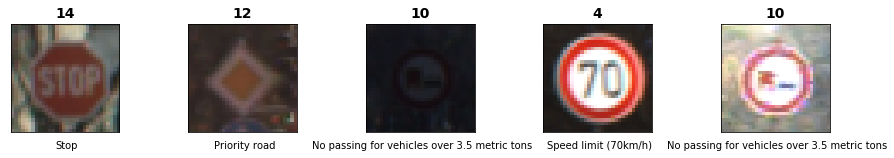

In [6]:
_ = plot_random_samples(X_train, y_train)

Now let us have a look at the **validation** and **testing** set:

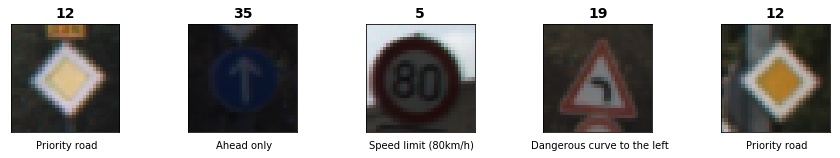

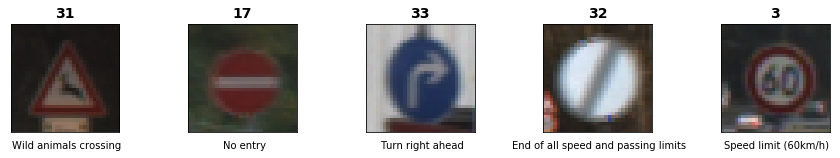

In [7]:
_ = plot_random_samples(X_valid, y_valid)
_ = plot_random_samples(X_test, y_test)

Looking at the images we can notice that there is a brightness shift, we may want to normalize the images or play around with the diffferent color channels in a pre-processing step.

Let us now try to plot the distribution on a bar chart:

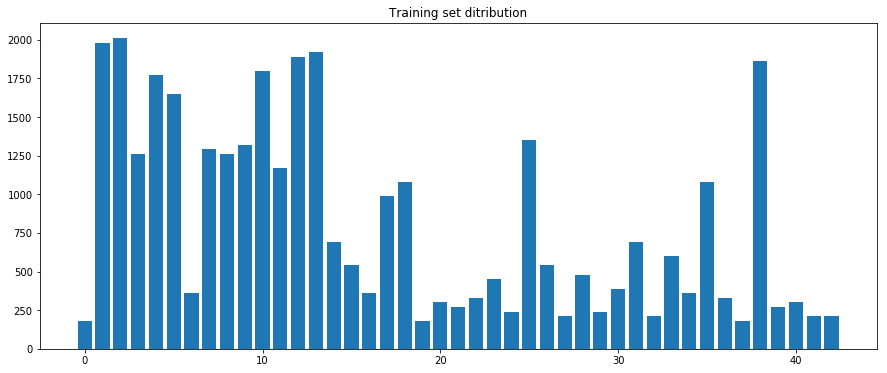

In [8]:
def plot_distribution(y, title, stack = None):
    classes, count = np.unique(y, return_counts=True)
    plt.figure(figsize = (15, 6))
    plt.title(title)
    plt.bar(classes, count)
    if stack is not None:
        for y_opt in stack:
            classes_opt, count_opt = np.unique(y_opt, return_counts = True)
            plt.bar(classes_opt, count_opt)
    plt.show()

plot_distribution(y_train, 'Training set ditribution')
    

The ditribution of the classes is not uniform and several contains very few examples, this may lead to poor perfomance on any model. Already from this we could think of augmenting the dataset. Let us have a look at the distribution of the validation and testing set:

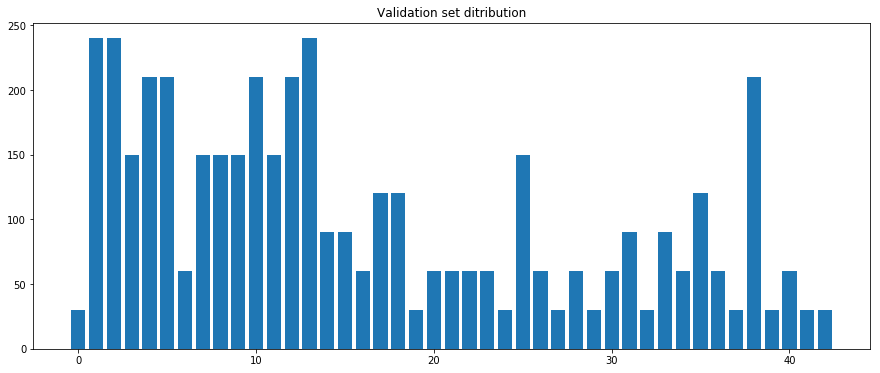

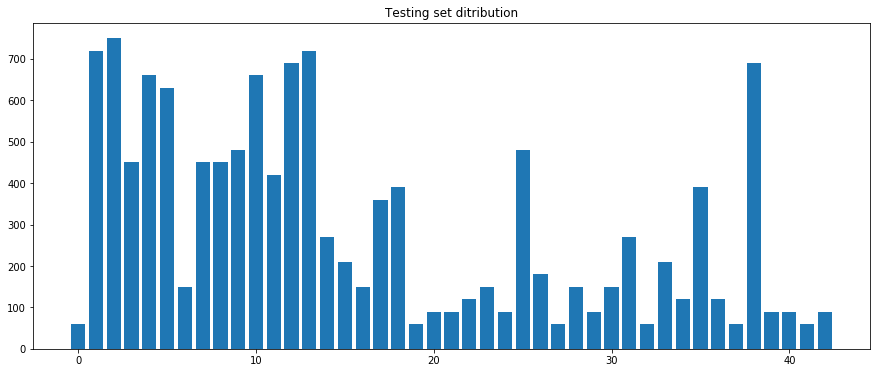

In [9]:
plot_distribution(y_valid, 'Validation set ditribution')
plot_distribution(y_test, 'Testing set ditribution')

We can notice that the distribution of the samples is the same among the various datasets, this is good news especially for the validation and test dataset that should be drawn from the same distribution.

----

## Step 2: Model Architecture Design and Testing

We start with analyzing the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) and think about pre-processing steps. We move on defining our architecture and finally training and testing.

### Pre-process the Data Set

In the following we proceed normalizing the dataset and equalizing the histogram of the images to have a better balance in the brightness of the images.

#### Normalization and histogram equalization

We can start with a minimal normalization and preprocessing and come back later if needed. We can notice that the images have a strong shift in brightness. We can apply a histogram equalization to fix the contrast, from https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html we can try using Contrast Limited Adaptive Histogram Equalization (CLAHE) that seems to yield better results:

In [10]:
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle

# Contrast Limited Adaptive Histogram Equalization
CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))

def normalize_data(X, a = -.5, b = .5, X_min = 0, X_max = 255):
    return a + ((X - X_min) * (b - a)) / (X_max - X_min)
    #return (X - 128.)/128.
    
def hist_equalize(img, clahe = None):
    # Convert to LAB color space
    converted = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # Equalize the histogram on the L channel only
    converted[:,:,0] = cv2.equalizeHist(converted[:,:,0]) if clahe is None else clahe.apply(converted[:,:,0])

    return cv2.cvtColor(converted, cv2.COLOR_LAB2RGB)

def preprocess_image(img):
    img = hist_equalize(img, clahe = CLAHE)
    return img

def preprocess_data(X, y, normalize = True, shuffle_data = True):
    images = []
    
    for img in tqdm(X, unit=' images', desc='Pre-processing'):
        images.append(preprocess_image(img))
    
    X = np.array(images)
    
    if normalize:
        X = normalize_data(X)

    if shuffle_data:
        X, y = shuffle(X, y)
    
    return X, y

X_train_processed, y_train_processed = preprocess_data(X_train, y_train, normalize = False, shuffle_data = False)

Pre-processing: 100%|██████████| 34799/34799 [00:03<00:00, 11232.41 images/s]


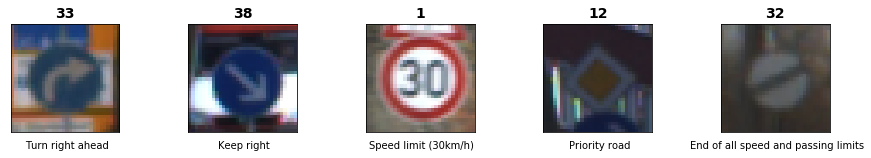

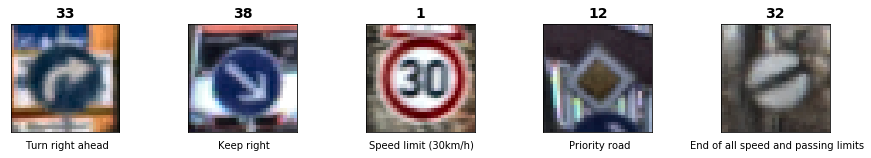

In [13]:
indices = plot_random_samples(X_train, y_train)

plot_images(X_train_processed, y_train_processed, indices)

The image brightness and contrast is now better balanced, this will allow the model to generalize better on the features of the images without worrying too much about brightness shift.

#### Data Augmentation

From the previous section we can notice that the distribution of the various classes in the dataset is not uniform and there are classes with very few examples. We can notice from the images in the dataset that some of can be mirrored retaining the same class (e.g. yield, stop etc.), while others can be mirrored but their class is swaped (E.g. keep left -> keep right etc). As a first step we can therefore simply mirror horizontally those classes and add it back to the dataset:

In [14]:
def mirror_images(X, y):
    mirror_map = {
        11: 11,
        12: 12,
        13: 13,
        15: 15,
        17: 17,
        18: 18,
        19: 20,
        20: 19,
        22: 22,
        26: 26,
        30: 30,
        33: 34,
        34: 33,
        35: 35,
        36: 37,
        37: 36, 
        38: 39,
        39: 38
    }
    
    classes, count = np.unique(y, return_counts = True)
    
    mean = np.ceil(np.mean(count)).astype('uint32')
    
    additional_x = []
    additional_y = []
    
    for cls in tqdm(classes, unit=' classes', desc='Mirroring'):
        
        images_in_class = np.where(y == cls)[0]
        if cls in mirror_map:
            mirror_cls = mirror_map[cls]
            mirrored_h = X[images_in_class][:, :, ::-1, :]
            mirrored_h = mirrored_h[0:mean]
            additional_x.extend(mirrored_h)
            additional_y.extend(np.full((len(mirrored_h)), mirror_cls, dtype = int))

    additional_x = np.array(additional_x)
    additional_y = np.array(additional_y)
        
    X = np.concatenate((X, additional_x), axis = 0)
    y = np.concatenate((y, additional_y), axis = 0)
    
    return X, y
    
X_train_mirrored, y_train_mirrored = mirror_images(X_train, y_train)

print("Total number of samples: {} (Originally: {})".format(len(X_train_mirrored), len(X_train)))


Mirroring: 100%|██████████| 43/43 [00:00<00:00, 2276.15 classes/s]

Total number of samples: 44488 (Originally: 34799)


With this we gained a fair amount of new samples basically for free, note that we mirrored only horizontally to be careful as we want to avoid a wrong generalization of the model.

Next we can plot the distribution again of the augmented dataset with the mirrored images:

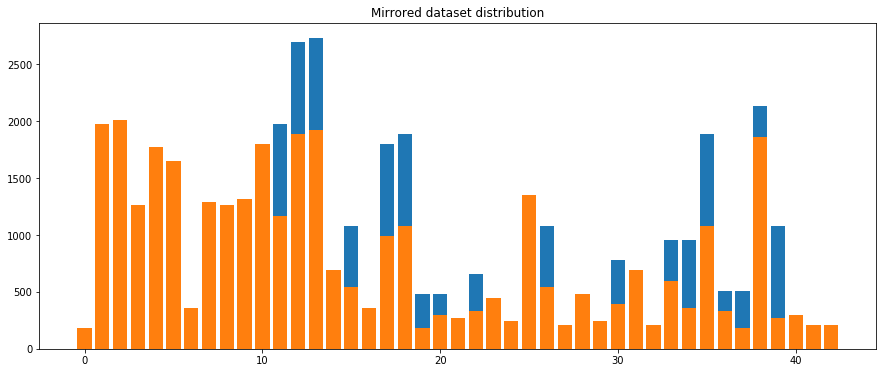

In [15]:
plot_distribution(y_train_mirrored, 'Mirrored dataset distribution', [y_train])

The dataset is still not uniform, we further augment the training set generating random geometric transformations on the images:

In [16]:
import cv2

def scale_image(img, x_factor=0.85, y_factor=0.85, border = 5):
    row_i, col_i, _ = img.shape
    
    img = cv2.resize(img, None, fx = x_factor, fy = y_factor)
    
    img = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_REPLICATE)
    
    row, col, _ = img.shape
    
    row_gap = round((row - row_i) / 2)
    col_gap = round((col - col_i) / 2)
    
    return img[row_gap:row_i + row_gap, col_gap:col_i + col_gap]

def translate_image(img, x = 5, y = 5, border = 5):
    img = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_REPLICATE)
    
    row, col, _ = img.shape

    trans_m = np.float32([[1, 0, x],[0, 1, y]])
    
    img = cv2.warpAffine(img, trans_m, (col, row))
    
    return img[border:row - border, border:col - border]

def transform_perspective(img, delta = [2, 2, 2, 2], border = 5):
    img = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_REPLICATE)
    
    row, col, _ = img.shape
    
    # Top left
    x1 = delta[0]
    y1 = delta[0]
    # Top right
    x2 = col - delta[1]
    y2 = delta[1]
    # Bottom left
    x3 = delta[2]
    y3 = row - delta[2]
    # Bottom right
    x4 = col - delta[3]
    y4 = row - delta[3]
    
    pts1 = np.float32([[x1, y1],[x2, y2],[x3, y3],[x4, y4]])
    pts2 = np.float32([[0, 0],[col, 0],[0, row],[col, row]])
    
    persp_m = cv2.getPerspectiveTransform(pts1,pts2)
    
    img = cv2.warpPerspective(img, persp_m , (row, col))
    
    return img[border:row - border, border:col - border]

def rotate_image(img, angle = 15, border = 5):
    img = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_REPLICATE)

    row, col, _ = img.shape

    rot_m = cv2.getRotationMatrix2D((row / 2, col / 2), angle, 1)

    img = cv2.warpAffine(img, rot_m, (col, row))
    
    return img[border:row - border, border:col - border]

def adjust_gamma(img, gamma = 1.0):
    invGamma = 1.0 / gamma
    
    gamma_m = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(img, gamma_m)

def random_transform(img):
    mask = np.random.randint(0, 2, [1, 5])[0]
    
    if np.sum(mask) == 0:
        mask[np.random.randint(5)] = 1

    if mask[0] == 1:
        img = scale_image(img, x_factor = np.random.uniform(0.85, 1.15), y_factor = np.random.uniform(0.85, 1.15))
    if mask[1] == 1:
        img = translate_image(img, x = np.random.randint(-3, 3), y = np.random.randint(-2, 2))
    if mask[2] == 1:
        img = adjust_gamma(img, gamma = np.random.uniform(0.8, 1.2))
    if mask[3] == 1:
        img = rotate_image(img, angle = np.random.uniform(-15, 15))
    if mask[4] == 1:
        img = transform_perspective(img, [np.random.uniform(-7, 7) for i in range(4)])
        
    return img

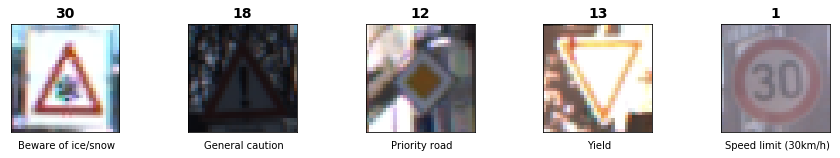

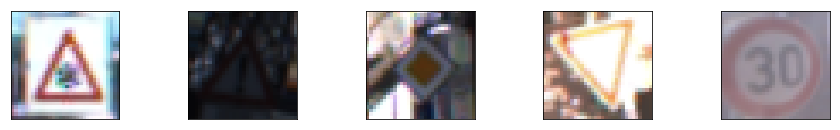

In [18]:
indices = plot_random_samples(X_train, y_train)

transformed_images = []

for i in indices:
    transformed_images.append(random_transform(X_train[i]))
    
plot_images(transformed_images)

We can therefore continue generating new images for the under represented classes:

In [19]:
def augment_dataset(X, y):
    
    additional_x = []
    additional_y = []
    
    classes, count = np.unique(y, return_counts = True)
    
    min_desired = np.max(count)
    
    for cls in tqdm(classes, unit=' classes', desc='Data Augmentation'):
        images_in_class = np.where(y == cls)[0]
        
        curr_count = count[cls]
        
        if curr_count < min_desired:
            missing_count = min_desired - curr_count
            choice = np.random.choice(images_in_class, missing_count, replace = missing_count > curr_count)
            for index in choice:
                img = X[index]
                additional_x.append(random_transform(img))
                additional_y.append(cls)
        
    additional_x = np.array(additional_x)
    additional_y = np.array(additional_y)
    
    X = np.concatenate((X, additional_x), axis = 0)
    y = np.concatenate((y, additional_y), axis = 0)
    
    return X, y

def load_or_augment(X, y, data_dir = DATA_DIR, filename = 'train_augmented.p', force_generate = False):
    
    filename = os.path.join(data_dir, filename)
    
    if not force_generate and os.path.isfile(filename):
        print('Augmented dataset already generated, loading from pickle file.')
        
        with open(filename, 'rb') as f:
            dataset = pickle.load(f)
        
        X, y = dataset['features'], dataset['labels']
    else:
        X, y = mirror_images(X, y)
        X, y = augment_dataset(X, y)

        print("Saving augmented dataset to {}".format(filename))

        dataset = {
            'features': X,
            'labels': y
        }
        
        with open(filename, 'wb') as f:   
            pickle.dump(dataset, f, protocol = pickle.HIGHEST_PROTOCOL)
    
    return X, y

X_train_augmented, y_train_augmented = load_or_augment(X_train, y_train, force_generate = False)

print("Total number of samples: {} (Originally: {})".format(len(X_train_augmented), len(X_train)))

Augmented dataset already generated, loading from pickle file.
Total number of samples: 117390 (Originally: 34799)


We can now view some of the generated images:

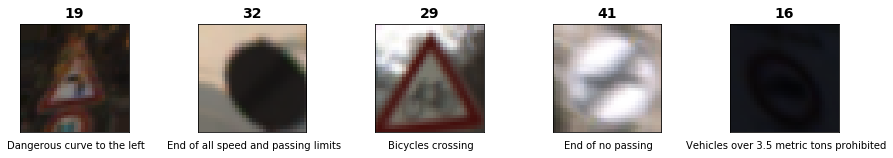

In [20]:
_ = plot_random_samples(X_train_augmented, y_train_augmented, from_index = len(X_train))

And the current distribution of the dataset:

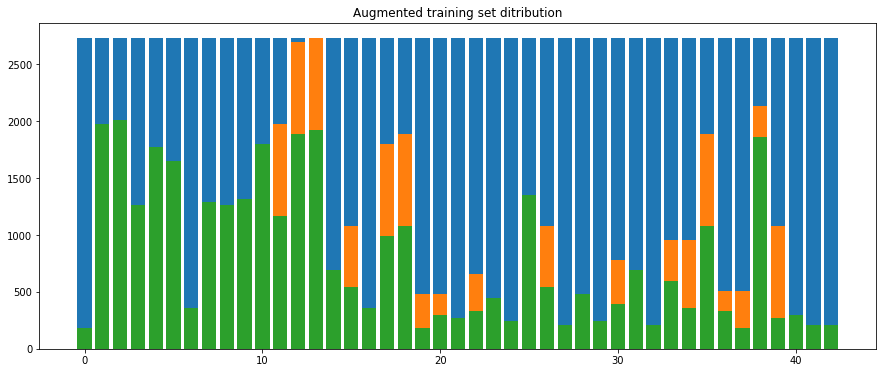

In [21]:
plot_distribution(y_train_augmented, 'Augmented training set ditribution', [y_train_mirrored, y_train])

We are now ready to build our final datasets, applying augmentation and preprocessing. Note that we need to preprocess all the datasets to get consistent results, while data augmentation can be applied only to the training set if we keep the validation and test sets distribution the same:

In [22]:
X_train_final, y_train_final = preprocess_data(X_train_augmented, y_train_augmented)
X_valid_final, y_valid_final = preprocess_data(X_valid, y_valid, shuffle_data = False)
X_test_final , y_test_final  = preprocess_data(X_test, y_test, shuffle_data = False)

Pre-processing: 100%|██████████| 12630/12630 [00:01<00:00, 12039.81 images/s]


### Model Architecture

Let us start defining some basic operations that we'll need to build the model and a base class that we use to build our models. In particular we implement a flexible class that allows us to try out several different techniques for improving our model. The following implements L2 regularization, batch normalization, flexible dropout for the fully connected layers and all the operations that we will later need to train, evaluate and use our model (e.g. run predictions). We use gradient descent with adam optimization as it seems to provide good results and needs less tweaking for batch size. For the loss we use cross entropy that for the given dataset is a good choice since it is designed to computed the probability error in discrete classification tasks when the classes are mutually exclusive.

In [183]:
import time
import tensorflow as tf
from tensorflow.contrib.layers import flatten

MODEL_DIR = 'models'
MODEL_EXT = '.ckpt'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

class ConvNet:
    
    def __init__(self, model_name, cfg, n_classes, l2_reg = False, batch_normalize = False):
        '''
        Builds a ConvNet with the given name and configuration.
        
        Input:
            - model_name: name of the model
            - cfg: The configuration of the model, an array of steps where each step is an array such as:
                   Convolution    : ('C', output_ch, filter_size, padding_type, max_pooling)
                   Fully Connected: ('F', output_size)
                   Logits         : ('L', output_size)

                   Note that for the convolution layer the max_pooling defines the parameter k, if omitted no
                   max pooling is applied
            - n_classes: Number of output classes
            - l2_reg: Boolean, true if l2 regularization should be enabled
            - batch_normalize: Boolean, true if batch normalization should be applied to the fully connected layers
        '''
        # Used in the weights inizialization
        self.mu = 0
        self.sigma = 0.1
        
        self.cfg = cfg
        self.l2_reg = l2_reg
        self.batch_normalize = batch_normalize
        self.model_name = model_name
        self.n_classes = n_classes
        self._init_placeholders()
        self.weights = []
        self.activations = []
        self.logits = self._build_model()
        self._init_operations()

    def _init_placeholders(self):
        self.features = tf.placeholder(tf.float32, (None, 32, 32, 3), name = 'features')
        self.labels = tf.placeholder(tf.int32, (None), name = 'labels')
        self.labels_encoded = tf.one_hot(self.labels, n_classes)
        self.learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
        self.keep_probability = tf.placeholder(tf.float32, name = 'keep_probability')
        # Decay and training phase for batch normalization
        self.bn_decay = tf.placeholder(tf.float32, name = 'bn_decay')
        self.is_training = tf.placeholder(tf.bool, name ='is_training')
        # Beta for L2 regularization
        self.l2_beta = tf.placeholder(tf.float32, name = 'l2_beta')
        
    def _init_operations(self):
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = self.labels_encoded, logits = self.logits)
        self.loss = tf.reduce_mean(cross_entropy)
        
        regularizers = 0.0
        
        # L2 regularization
        if self.l2_reg:
            
            for weight in self.weights:
                regularizers += tf.nn.l2_loss(weight)
            
            self.loss = tf.reduce_mean(self.loss + self.l2_beta * regularizers)
        
        # Keeps track of the training steps
        self.global_step = tf.Variable(0)
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        # For batch normalization
        with tf.control_dependencies(update_ops):
            # Gradient descent with adam optimization
            self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.loss, global_step = self.global_step)
        
        self.prediction = tf.argmax(self.logits, 1)
        correct_prediction = tf.equal(self.prediction, tf.argmax(self.labels_encoded, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    def _build_model(self):
        '''
        Builds the model from the configuration
        '''
        self.desc = []
        
        x = self.features
        
        for step in self.cfg:

            step_type  = step[0]
            
            input_shape = x.get_shape().as_list()
            
            input_size = input_shape[1] if len(input_shape) == 2 else input_shape[3]
            output_size = step[1]
            
            if step_type == 'C':
                
                filter_size = step[2]
                padding = step[3]
                
                w, b = self._weights_and_biases(input_size, output_size, filter_size)
                x = self._convolution_relu(x, w, b, padding = padding)
                
                self.weights.append(w)
                self.activations.append(x)
                
                desc = "Conv (Input: {}, {}@{}x{}, pad = {})".format(input_size, output_size, filter_size, filter_size, padding)
                
                if len(step) == 5:
                    x = self._max_pooling(x, k = step[4])
                    desc +=", Max Pooling ({})".format(step[4])
                
                self.desc.append(desc)
                
            elif step_type == 'F':
                
                if not len(input_shape) == 2:
                    x = flatten(x)
                    input_size = x.get_shape().as_list()[1]
                    
                w, b = self._weights_and_biases(input_size, output_size)
                
                x = self._fully_connected(x, w, b)
                
                self.weights.append(w)
                self.activations.append(x)
                
                x = tf.nn.dropout(x, keep_prob = self.keep_probability)
                
                self.desc.append("Fully Connected ({}x{}, Dropout)".format(input_size, output_size))
                
            elif step_type == 'L':
                
                w, b = self._weights_and_biases(input_size, output_size)              
                
                x = self._fully_connected(x, w, b, relu = False)
                
                self.weights.append(w)
                self.desc.append("Out ({}x{})".format(input_size, output_size))
                
        return x
        
    def _get_model_file(self, run_n):
        return os.path.join(MODEL_DIR, self.model_name + ('_' + str(run_n) if run_n > 0 else '') + MODEL_EXT)
    
    def _weights_and_biases(self, input_ch, output_ch, filter_size = None):
        shape = (input_ch, output_ch) if filter_size is None  else (filter_size, filter_size, input_ch, output_ch)

        w = tf.Variable(tf.truncated_normal(shape = shape, mean = self.mu, stddev = self.sigma))    
        b = tf.Variable(tf.zeros(output_ch))

        return w, b
    
    def _fully_connected(self, x, W, b, relu = True):
        x = tf.matmul(x, W)
        x = tf.nn.bias_add(x, b)
        if self.batch_normalize:
            # Unfortunately fused = True does not work with older version of tensorflow (e.g. 0.12.1)
            x = tf.contrib.layers.batch_norm(x, center = True, fused = False, decay = self.bn_decay, is_training = self.is_training)
        if relu:
            x = tf.nn.relu(x)
        return x

    def _convolution_relu(self, x, W, b, s = 1, padding = 'VALID'):
        x = tf.nn.conv2d(x, W, strides = [1, s, s, 1], padding = padding)
        x = tf.nn.bias_add(x, b)
        x = tf.nn.relu(x)
        return x

    def _max_pooling(self, x, k = 2, padding = 'VALID'):
        x = tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = padding)
        return x
    
    def summary(self):
        for step in self.desc:
            print(step)
        
    def train(self, params, restore = False):
        '''
        Runs the training on the model.
        
        Input:
            - params: A dictionary containing the hyper parameters for the training:
                run_n: The run number (e.g. number of experiment), used to save the model
                X: The train set input features
                y: The train set labels
                X_valid: The validation set input features
                y_valid: The validation set labels
                epochs: The number of epochs
                batch_size: The size of the mini batches
                learning_rate: The initial learning rate
                keep_probability: The probability (one-minus) for the dropout
                l2_beta: Beta for l2 regularization (if enabled)
                bn_decay: The decay for batch normalization (if enabled)
            - restore: Boolean, if true restores the model from the latest checkpoint
            
        Output:
            Training and validation log containing each an array of pairs (loss, accuracy) computed at each epoch
        '''
        # Unpack params
        run_n            = params['run_n']
        X                = params['X']
        y                = params['y']
        X_valid          = params['X_valid']
        y_valid          = params['y_valid']
        epochs           = params['epochs']
        batch_size       = params['batch_size']
        learn_rate       = params['learning_rate']
        keep_p           = params['keep_probability']
        l2_reg_beta      = params['l2_beta']
        batch_norm_decay = params['bn_decay']
        
        filepath         = self._get_model_file(run_n)

        # Used later on for plotting
        train_log = []
        valid_log = []

        saver = tf.train.Saver()

        with tf.Session() as sess:

            if restore:
                self.restore(params, sess)
            else:        
                sess.run(tf.global_variables_initializer())

            num_examples = len(X)

            print("Training {} #{}, {} samples (EP: {}, BS: {}, LR: {}, KP: {}, L2: {}, BN: {})...".format(
                self.model_name, run_n, num_examples, epochs, batch_size, learn_rate, keep_p,
                l2_reg_beta if self.l2_reg else 'OFF',
                batch_norm_decay if self.batch_normalize else 'OFF'
            ))
            print()

            start = time.time()

            for i in range(epochs):
                # Shuffle dataset on each epoch
                X, y = shuffle(X, y)

                start_ep = time.time()
                
                #offset_it = tqdm(range(0, num_examples, batch_size), unit = ' Batches', desc = 'EPOCH {}'.format(i + 1))
                
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size

                    batch_x, batch_y = X[offset:end], y[offset:end]
                    
                    feed_dict = {
                        self.features: batch_x, 
                        self.labels: batch_y, 
                        self.learning_rate: learn_rate, 
                        self.keep_probability: keep_p,
                        self.l2_beta: l2_reg_beta,
                        self.bn_decay: batch_norm_decay,
                        self.is_training: True
                    }

                    _ = sess.run(self.optimizer, feed_dict = feed_dict)

                train_loss, train_acc = self.evaluate(X, y, params, sess)
                train_log.append([train_loss, train_acc])
                
                valid_loss, valid_acc = self.evaluate(X_valid, y_valid, params, sess)
                valid_log.append([valid_loss, valid_acc])

                elapsed_ep = time.time() - start_ep
                
                steps = sess.run(self.global_step)

                print("EPOCH {} ({:.1f} s, {}): Train Loss/Accuracy: ({:.4f}, {:.4f}) Validation Loss/Accuracy: ({:.4f}, {:.4f})".format(
                    i + 1, elapsed_ep, steps, train_loss, train_acc, valid_loss, valid_acc
                ))

            elapsed = time.time() - start
            print("Training finished ({:.1f} s)".format(elapsed))
            
            save_path = saver.save(sess, filepath)
            print("Model saved in path:", save_path)
            
            return np.array(train_log), np.array(valid_log)
        
    def restore(self, params, sess):
        '''
        Restores a model and returns a session
        '''
        saver = tf.train.Saver()
        run_n = params['run_n']
        saver.restore(sess, self._get_model_file(run_n))
        
    def evaluate(self, X, y, params, sess):
        '''
        Evaluates the model on the given dataset
        
        Input:
            - X: The input features
            - y: The labels
            - params: Dictionary containing the parameters for the model
                batch_size: The size of the minibatches
                l2_beta: Beta for l2 regularization (if enabled)
                bn_decay: The decay for batch normalization (if enabled)
        
        Output:
            (loss, accuracy) pair
        '''
        num_examples = len(X)
        
        batch_size       = params['batch_size']
        l2_reg_beta      = params['l2_beta']
        batch_norm_decay = params['bn_decay']
        
        total_loss = 0
        total_accuracy = 0
            
        for offset in range(0, num_examples, batch_size):

            batch_x, batch_y = X[offset:offset + batch_size], y[offset:offset + batch_size]

            feed_dict = {
                self.features: batch_x,
                self.labels: batch_y,
                self.keep_probability: 1,
                self.l2_beta: l2_reg_beta,
                self.bn_decay: batch_norm_decay,
                self.is_training: False
            }
            
            loss, accuracy = sess.run([self.loss, self.accuracy], feed_dict = feed_dict)

            total_loss += (loss * len(batch_x))
            total_accuracy += (accuracy * len(batch_x))

        return total_loss / num_examples, total_accuracy / num_examples
        
    def predict(self, X, params, sess):
        
        l2_reg_beta      = params['l2_beta']
        batch_norm_decay = params['bn_decay']
            
        feed_dict = {
            self.features: X,
            self.keep_probability: 1,
            self.l2_beta: l2_reg_beta,
            self.bn_decay: batch_norm_decay,
            self.is_training: False
        }
        
        prob, pred = sess.run([tf.nn.softmax(self.logits), self.prediction], feed_dict = feed_dict)
        
        return pred, prob
        

#### Final Model

In the following we define our final model, choosen after several hours of experimentation and fine tuning. The model follows after the VGG architecture, having multiple convolutions followed by subsampling with maxpooling and finally using a fully connected layer with dropout. While there are probably better model architectures out there (e.g. ResNet, inception etc) the VGG is very simple to implement and I added different pieces to improve the model such as L2 regularization and batch normalization.

In [184]:
def VGGLikeNetV8(l2_reg = False, batch_normalize = False):
    '''
    Input: 32x32x3
    -> Conv (3x3x32  pad = SAME)
    -> Conv (3x3x32  pad = SAME), MaxPooling
    -> Conv (3x3x64  pad = SAME)
    -> Conv (3x3x64  pad = SAME), MaxPooling
    -> Conv (3x3x128 pad = SAME)
    -> Conv (3x3x128 pad = SAME), MaxPooling, Flatten
    -> FC   (2048x512)          , Dropout
    -> FC   (256x43)
    '''
    cfg = [('C',  32, 3, 'SAME'),    # 32x32x32
           ('C',  32, 3, 'SAME', 2), # 16x16x32
           ('C',  64, 3, 'SAME'),    # 16x16x64
           ('C',  64, 3, 'SAME', 2), # 8x8x64
           ('C', 128, 3, 'SAME'),    # 8x8x128
           ('C', 128, 3, 'SAME', 2), # 4x4x128
           ('F', 512),
           ('L', n_classes)]
    
    return ConvNet('VGGLikeNetV8', cfg, n_classes, l2_reg = l2_reg, batch_normalize = batch_normalize)

model = VGGLikeNetV8(True, True)
model.summary()

Conv (Input: 3, 32@3x3, pad = SAME)
Conv (Input: 32, 32@3x3, pad = SAME), Max Pooling (2)
Conv (Input: 32, 64@3x3, pad = SAME)
Conv (Input: 64, 64@3x3, pad = SAME), Max Pooling (2)
Conv (Input: 64, 128@3x3, pad = SAME)
Conv (Input: 128, 128@3x3, pad = SAME), Max Pooling (2)
Fully Connected (2048x512, Dropout)
Out (512x43)


In the following we include a visual representation of the choosen model:

![VGGLikeNetV8 Architecture](images/model_architecture.png)

### Other Architectures

In the following we provide additional models that we tried during the experimentation and fine tuning, in particular I started from the LeNet based architecture and built on top of it. After reaching a limit in the accuracy achieved I decided to eperiment with deeper networks and switched to a VGG oriented architecture performing several experiments to find the best fitting layer architecture. I implemented an adapted version of VGG13 but found it was too slow with the resources at my disposal, so I removed one layer. Finally I implemented the final model removing one of the fully connected layers that proved to perform better:

In [25]:
# Base LeNet architecture
def LeNet(l2_reg = False, batch_normalize = False):
    '''
    Input: 32x32x3
    -> Conv (5x5x6  pad = VALID), MaxPooling          
    -> Conv (5x5x16 pad = VALID), MaxPooling, Flatten
    -> FC   (400x120)           , Dropout
    -> FC   (120x84)            , Dropout
    -> FC   (84x43)
    '''
    cfg = [('C',   6, 5, 'VALID', 2), # 14x14x6
           ('C',  16, 5, 'VALID', 2), # 5x5x16
           ('F', 120),
           ('F',  84),
           ('L', n_classes)]
    
    return ConvNet('LeNet', cfg, n_classes)        

# A modification of LeNet, deeper that yield better results
def LeNetMod(l2_reg = False, batch_normalize = False):
    '''
    Input: 32x32x3
    -> Conv (3x3x32  pad = VALID), MaxPooling
    -> Conv (3x3x64  pad = VALID), MaxPooling
    -> Conv (3x3x128 pad = VALID), MaxPooling, Flatten
    -> FC   (512x512)            , Dropout
    -> FC   (512x256)            , Dropout
    -> FC   (256x43)
    '''
    cfg = [('C',  32, 3, 'VALID', 2), # 15x15x32
           ('C',  64, 3, 'VALID', 2), # 6x6x64
           ('C', 128, 3, 'VALID', 2), # 2x2x128
           ('F', 512),
           ('F', 256),
           ('L', n_classes)]
    
    return ConvNet('LeNetMod', cfg, n_classes, l2_reg = l2_reg, batch_normalize = batch_normalize)

# First try with a VGG like architecture
def VGGLikeNet(l2_reg = False, batch_normalize = False):
    '''
    Input: 32x32x3
    -> Conv (3x3x32  pad = VALID)
    -> Conv (3x3x32  pad = VALID), MaxPooling
    -> Conv (3x3x64  pad = VALID)
    -> Conv (3x3x64  pad = VALID), MaxPooling
    -> Conv (3x3x128 pad = VALID), Flatten
    -> FC   (1152x512)           , Dropout
    -> FC   (512x256)            , Dropout
    -> FC   (256x43)
    '''
    cfg = [('C',  32, 3, 'VALID'),    # 30x30x32
           ('C',  32, 3, 'VALID', 2), # 14x14x32
           ('C',  64, 3, 'VALID'),    # 12x12x64
           ('C',  64, 3, 'VALID', 2), # 5x5x64
           ('C', 128, 3, 'VALID'),    # 3x3x128
           ('F', 512),
           ('F', 256),
           ('L', n_classes)]
    
    return ConvNet('VGGLikeNet', cfg, n_classes, l2_reg = l2_reg, batch_normalize = batch_normalize)

# Try with a very close version of VGG 13
def VGGLikeNetV2(l2_reg = False, batch_normalize = False):
    '''
    Input: 32x32x3
    -> Conv (3x3x32  pad = SAME)
    -> Conv (3x3x32  pad = SAME), MaxPooling
    -> Conv (3x3x64  pad = SAME)
    -> Conv (3x3x64  pad = SAME), MaxPooling
    -> Conv (3x3x128 pad = SAME)
    -> Conv (3x3x128 pad = SAME), MaxPooling
    -> Conv (3x3x256 pad = SAME)
    -> Conv (3x3x256 pad = SAME), MaxPooling, Flatten
    -> FC   (1024x512)          , Dropout
    -> FC   (512x512)           , Dropout
    -> FC   (512x43)
    '''
    cfg = [('C',   32, 3, 'SAME'),    # 32x32x32
           ('C',   32, 3, 'SAME', 2), # 16x16x32
           ('C',   64, 3, 'SAME'),    # 16x16x32
           ('C',   64, 3, 'SAME', 2), # 8x8x32
           ('C',  128, 3, 'SAME'),    # 8x8x128
           ('C',  128, 3, 'SAME', 2), # 4x4x128
           ('C',  256, 3, 'SAME'),    # 4x4x256
           ('C',  256, 3, 'SAME', 2), # 2x2x256
           ('F',  512),
           ('F',  512),
           ('L',  n_classes)]
    
    return ConvNet('VGGLikeNetV2', cfg, n_classes, l2_reg = l2_reg, batch_normalize = batch_normalize)

# Removes one layer from the version V2, to speed up training
def VGGLikeNetV6(l2_reg = False, batch_normalize = False):
    '''
    Input: 32x32x3
    -> Conv (3x3x32  pad = SAME)
    -> Conv (3x3x32  pad = SAME), MaxPooling
    -> Conv (3x3x64  pad = SAME)
    -> Conv (3x3x64  pad = SAME), MaxPooling
    -> Conv (3x3x128 pad = SAME)
    -> Conv (3x3x128 pad = SAME), MaxPooling, Flatten
    -> FC   (2048x512)          , Dropout
    -> FC   (512x256)           , Dropout
    -> FC   (256x43)
    '''
    cfg = [('C',  32, 3, 'SAME'),    # 32x32x32
           ('C',  32, 3, 'SAME', 2), # 16x16x32
           ('C',  64, 3, 'SAME'),    # 16x16x64
           ('C',  64, 3, 'SAME', 2), # 8x8x64
           ('C', 128, 3, 'SAME'),    # 8x8x128
           ('C', 128, 3, 'SAME', 2), # 4x4x128
           ('F', 512),
           ('F', 256),
           ('L', n_classes)]
    
    return ConvNet('VGGLikeNetV6', cfg, n_classes, l2_reg = l2_reg, batch_normalize = batch_normalize)

### Summary of architectures:

In the following table we provide an overall summary of the main architectures that were tested during the experimentation. Note that other architectures were tested, in particular trying different sizes for the convolutions and fully connected layers, these are the ones that were focused on during the last part of the experimentation:

![Models](images/models.png)

Note that while in the initial testing no padding was used, later on after adding new layers, in order to preserve information on the border of the images zero padding was introduced.

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In the following we provide prepare an environment where we can run multiple experiments and then plot the results, in particular we plot the loss and accuracy during the training for both the training and validation datasets, this helps us understand how the model is doing in respect to the hyperparameters and allows us to better fine tune the model:

In [124]:
def plot_results(model, params, train_log, valid_log, test_loss, test_acc, save = True):
    
    model_name       = model.model_name
    run_n            = params['run_n']
    epochs           = params['epochs']
    batch_size       = params['batch_size']
    learning_rate    = params['learning_rate']
    keep_probability = params['keep_probability']
    l2_beta          = params['l2_beta']
    bn_decay         = params['bn_decay']

    # Get the training and validation loss/accuracy
    train_loss, train_acc = train_log[-1:][0]
    valid_loss, valid_acc = valid_log[-1:][0]
    
    text = 'Loss: {:.3f}, {:.3f}, {:.3f} - Accuracy: {:.3f}, {:.3f}, {:.3f}'.format(
        train_loss, valid_loss, test_loss,
        train_acc, valid_acc, test_acc)

    print(text)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    c1 = colors[0]
    c2 = colors[1]
    c3 = colors[2]
    c4 = colors[3]
    
    fig, ax1 = plt.subplots(figsize=(9, 6))
    
    ax1.set_xlabel('Epochs')
    
    x = np.arange(1, len(train_log) + 1)
    
    ax1.plot(x, train_log[:,0], label='Train Loss', color = c1)
    ax1.plot(x, valid_log[:,0], label='Validation Loss', color = c2)
    
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Loss', color = c1)
    ax1.tick_params('y', colors = c1)

    ax2 = ax1.twinx()
   
    ax2.plot(x, train_log[:,1], label='Train Accuracy', color = c3)
    ax2.plot(x, valid_log[:,1], label='Validation Accuracy', color = c4)
    
    ax2.set_ylabel('Accuracy', color = c3)
    ax2.tick_params('y', colors = c3)

    plt.title("{} (EP: {}, BS: {}, LR: {}, KP: {}, L2: {}, BN: {})".format(
        model_name, epochs, batch_size, learning_rate, 
        keep_probability,
        l2_beta if model.l2_reg else 'OFF',
        bn_decay if model.batch_normalize else 'OFF'
    ))
    
    fig.text(0.5, 0, text,
                verticalalignment='top', 
                horizontalalignment='center',
                color='black', fontsize=10)
    
    
    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    
    fig.legend(handles2 + handles, labels2 + labels, loc = (0.7, 0.5))
    fig.tight_layout()
    
    if save:
        fig.savefig(os.path.join(MODEL_DIR, model_name + ('_' + str(run_n) if run_n > 0 else '')), bbox_inches = 'tight')
    
    plt.show()
    
def run_experiments(experiments):
    
    results = []
    
    for exp_params in experiments:

        if exp_params['skip']:
            continue

        exp_model = exp_params['model']

        exp_l2_reg = exp_params['l2_reg']
        exp_batch_normalize = exp_params['batch_normalize']

        tf.reset_default_graph()

        exp_model = exp_model(l2_reg = exp_l2_reg, batch_normalize = exp_batch_normalize)

        # Train the model
        exp_train_log, exp_valid_log = exp_model.train(exp_params)
        
        # Evaluate
        with tf.Session() as sess:
            exp_model.restore(exp_params, sess)
            exp_test_loss, exp_test_acc = exp_model.evaluate(X_test_final, y_test_final, exp_params, sess)

            results.append([exp_model, exp_train_log, exp_valid_log, exp_test_loss, exp_test_acc])

            plot_results(exp_model, exp_params, exp_train_log, exp_valid_log, exp_test_loss, exp_test_acc)
    
    return results

In the cell below we define the experiments parameters, for brevity we only include here the final model parameters that we will use for testing and analyzing later on:

In [39]:
experiments = [
    {
        'run_n'           : 8,
        'model'           : VGGLikeNetV8,
        'l2_reg'          : True,
        'batch_normalize' : True,
        'X'               : X_train_final,
        'y'               : y_train_final,
        'X_valid'         : X_valid_final,
        'y_valid'         : y_valid_final,
        'epochs'          : 50,
        'batch_size'      : 128,
        'learning_rate'   : 0.00025,
        'keep_probability': 0.5,
        'l2_beta'         : 0.0001,
        'bn_decay'        : 0.9,
        'skip'            : False
    }
]

results = []

Training VGGLikeNetV8 #8, 117390 samples (EP: 50, BS: 128, LR: 0.00025, KP: 0.5, L2: 0.0001, BN: 0.9)...

EPOCH 1 (44.2 s, 918): Train Loss/Accuracy: (1.1578, 0.9548) Validation Loss/Accuracy: (1.2867, 0.9170)
EPOCH 2 (43.2 s, 1836): Train Loss/Accuracy: (0.7655, 0.9890) Validation Loss/Accuracy: (0.8467, 0.9673)
EPOCH 3 (43.4 s, 2754): Train Loss/Accuracy: (0.5963, 0.9956) Validation Loss/Accuracy: (0.6823, 0.9760)
EPOCH 4 (43.5 s, 3672): Train Loss/Accuracy: (0.4748, 0.9982) Validation Loss/Accuracy: (0.5659, 0.9807)
EPOCH 5 (43.5 s, 4590): Train Loss/Accuracy: (0.3755, 0.9989) Validation Loss/Accuracy: (0.4672, 0.9825)
EPOCH 6 (43.3 s, 5508): Train Loss/Accuracy: (0.3257, 0.9993) Validation Loss/Accuracy: (0.4223, 0.9803)
EPOCH 7 (43.5 s, 6426): Train Loss/Accuracy: (0.2621, 0.9998) Validation Loss/Accuracy: (0.3551, 0.9846)
EPOCH 8 (43.3 s, 7344): Train Loss/Accuracy: (0.2434, 0.9998) Validation Loss/Accuracy: (0.3296, 0.9857)
EPOCH 9 (43.5 s, 8262): Train Loss/Accuracy: (0.1961, 0

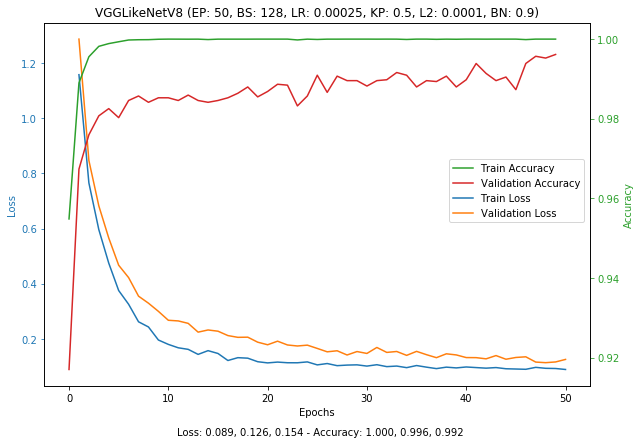

In [37]:
results = run_experiments(experiments)

Let us save the results and load the final model:

In [40]:
def save_results(train_log, valid_log, filename = 'models/final_results.p'):
    results = {
        'train': train_log,
        'valid': valid_log
    }
    with open(filename, 'wb') as f:   
        pickle.dump(results, f, protocol = pickle.HIGHEST_PROTOCOL)
        
def load_results(filename = 'models/final_results.p'):
    with open(filename, 'rb') as f:
        results = pickle.load(f)

    train_log, valid_log = results['train'], results['valid']
    return train_log, valid_log

if len(results) > 0:
    final_model, final_train_log, final_valid_log, final_test_loss, final_test_acc = results[0]
    save_results(final_train_log, final_valid_log)

INFO:tensorflow:Restoring parameters from models/VGGLikeNetV8_8.ckpt
Loss: 0.089, 0.126, 0.154 - Accuracy: 1.000, 0.996, 0.992


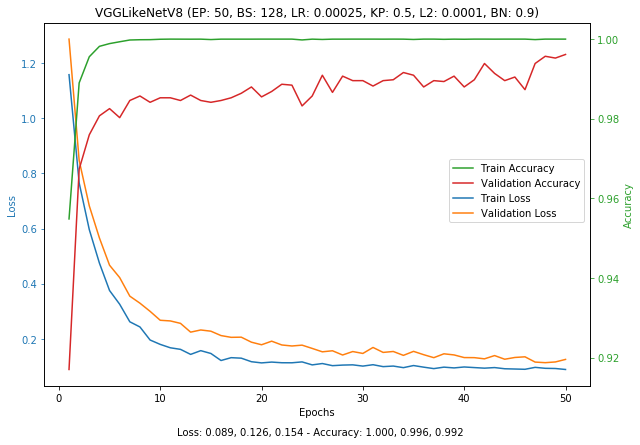

In [125]:
final_params = experiments[0]

if os.path.isfile('models/final_results.p'):
    final_train_log, final_valid_log = load_results()
    final_model = final_params['model']

    tf.reset_default_graph()

    final_model = final_model(l2_reg = final_params['l2_reg'], batch_normalize = final_params['batch_normalize'])

    with tf.Session() as sess:
        final_model.restore(final_params, sess)
        final_test_loss, final_test_acc = final_model.evaluate(X_test_final, y_test_final, final_params, sess)
        plot_results(final_model, final_params, final_train_log, final_valid_log, final_test_loss, final_test_acc)
    
elif len(results) == 0:
    print('Could not load the results from file and no experiment was run')

The model is trained with the following final parameters:

- Epochs: 50
- Batch size: 128
- Learning rate: 0.00025
- Dropout probability (Fully connected): 0.5
- L2 Beta: 0.0001
- Batch Norm Decay: 0.9

The accuracy reached by the model is as follow:

- Training: 1.0
- Validation: 0.996
- Testing: 0.992

An important aspect to notice is that the trend of the accuracy is increasing and the loss trend is decreasing. This may mean that the model could have been trained longer. In previous experiments with a lower learning rate the trend was more stable but accuracy and loss didn't improve anymore after certain amount of epochs. A good alternative would have been to use exponential decay, decreasing manually the learning rate for later epochs but this is still an open question for the adam optimizer.

In relative terms the model is probably overfitting and other experiments that I conducted have shown that increasing the beta parameter of the L2 regularization to 0.0002 or more helped in this but would have required a lot more epochs to reach the same accuracy.

Introducing batch normalization was a good choice, it helped a lot and provided also a bit of regularization. The dropout after the convolutional layers instead seemed to destabilize too much the training and I decided not to pursue in that direction too much leaving the dropout only after the fully connected layers. It provides a simple way to reduce overfitting and generalize better.

Let us plot the confusion matrix as well as the precision and recall of the model on the testing dataset for each class:

INFO:tensorflow:Restoring parameters from models/VGGLikeNetV8_8.ckpt


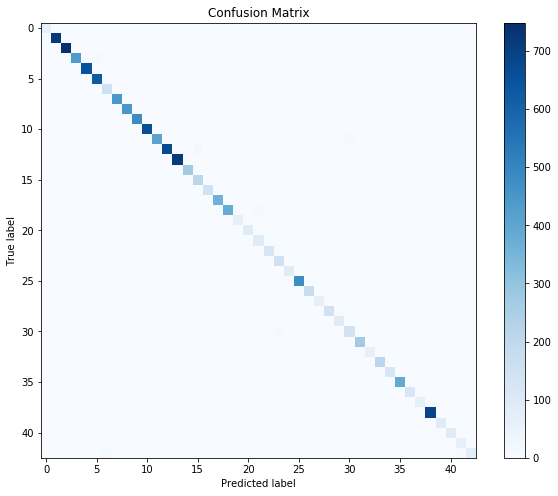

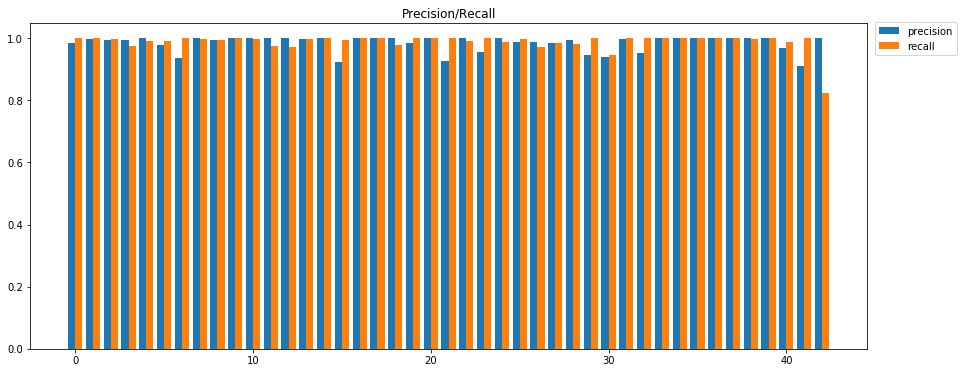

In [57]:
from sklearn import metrics

def plot_per_class_acc(params, X, y):

    tf.reset_default_graph()

    model = params['model'](True, True)
    
    with tf.Session() as sess:
        model.restore(params, sess)
        
        predictions, _ = model.predict(X, params, sess)
        
        precision = metrics.precision_score(y, predictions, average = None)
        recall = metrics.recall_score(y, predictions, average = None)
        
        # See http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        confusion_matrix = metrics.confusion_matrix(y, predictions)
        # Normalize
        #confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize = (10, 8))
        plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        
        plt.figure(figsize = (15, 6))
        plt.title("Precision/Recall")
        plt.bar(np.arange(n_classes), precision, width = -.4, align = 'edge', label = 'precision')
        plt.bar(np.arange(n_classes), recall, width = .4, align = 'edge', label = 'recall')
        plt.legend(loc = (1.01, 0.9))
        plt.show()
            
plot_per_class_acc(final_params, X_test_final, y_test_final)


We can notice that for one class (41 - End of no passing) the precision is relatively low while the recall is high, while for a second one (42 - End of no passing by veichles over 3.5 metric tons) the recall is around 80% while the precision is very high.

This means that the model interprets a too many things as "End of no passing", while its a bit more picky on the "End of no passing by veichles over 3.5 metric tons". Interestingly from the confusion matrix we can see that the correlation between the two, the " End of no passing" sign is often classified as the "End of no passing by veichles over 3.5 metric tons" sign.

Let us see some examples of those signs:

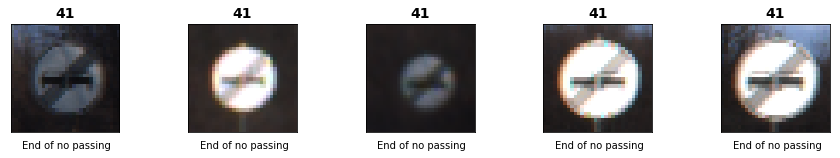

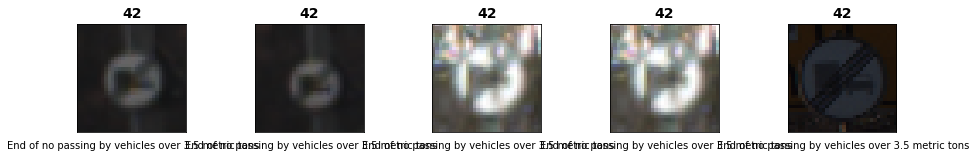

In [55]:
def plot_random_from_cls(X, y, cls, num = 5):
    img_in_cls = np.where(y == cls)[0]
    selected = np.random.choice(img_in_cls, size = num)
    
    plot_images(X[selected], y[selected])
    
plot_random_from_cls(X_test, y_test, 41)
plot_random_from_cls(X_test, y_test, 42)

The two signs are actually quite similar and probably due to the low resolution of the input images and the fact that the data augmentation made the dataset uniform played a role here. Those are both classes that were underepresented in the orginal dataset, so better augmentation for this two signs may actually help. The model didn't generalize well for the "End of no passing by veichles over 3.5 metric tons" so maybe too little variations were in the training set, while it generalized too much for the "End of no passing".

### Experiments

In the following section we provide a summary of the more relevant experiments that were conducted during the project:

#### Preliminary Experimentation (original dataset)

Initially I started out with the LeNet architecture and tested various normalization techniques and preprocessing, in particular I used min-max normalization and the histogram equalizer, using normal and CLAHE.

For all the experiments I used a batch size of 128 and a learning rate of 0.001 and few epochs (12).

This allowed me to settle for the on a min-max normalization between -0.5 and 0.5, I also decided to use the CLAHE histogram equalizer as they provided better results.

#### Initial data augmentation

I then proceeded with a first implementation of simple data augmentation and experiments with different parameters, in particular I experimented using the LeNet architecture, a modified version of LeNet and a VGG resembling version.

In this first version I implemeted dropout for the fully connected layers only and no regularization or batch normalization was introduced yet.

| Name       | # | EP | BS  | LR     | KP  | Accuracy (Train/Validation/Testing |
|------------|---|----|-----|--------|-----|------------------------------------|
| LeNet      | 1 | 10 | 64  | 0.001  | 1.0 | 0.990 / 0.944 / 0.567              |
| LeNet      | 2 | 20 | 128 | 0001   | 1.0 | 0.994 / 0.938 / 0.939              |
| LeNet      | 3 | 30 | 128 | 0.0001 | 1.0 | 0.956 / 0.910 / 0.902              |
| LeNetMod   | 1 | 20 | 128 | 0.0001 | 1.0 | 0.998 / 0.943 / 0.940              |
| LeNetMod   | 2 | 20 | 128 | 0.0001 | 0.7 | 0.997 / 0.967 / 0.964              |
| LeNetMod   | 3 | 20 | 128 | 0.0001 | 0.5 | 0.992 / 0.973 / 0.965              |
| VGGLikeNet | 1 | 20 | 128 | 0.0001 | 0.7 | 0.999 / 0.973 / 0.968              |
| VGGLikeNet | 2 | 20 | 128 | 0.0001 | 0.5 | 0.999 / 0.983 / 0.977              |
| VGGLikeNet | 3 | 20 | 512 | 0.0001 | 0.5 | 0.988 / 0.968 / 0.963              |

In particular I got down to a 0.0001 learning rate and a dropout probability of 0.5 in the fully connected layers. THe batch size of 128 seemed to work well across all the experiments.

#### Better augmentation

I then decided to go back and check my data augmentation and check if I could do better, I added the mirroring of images horizontally and better augmentation techniques such as scaling and perspective modification as well as brightness perturbation. I also implemented L2 regularization and batch normalization. The latter was giving good results but it is computationally very expensive:

| Name       | # | EP | BS  | LR     | KP  | L2     | BN  | Accuracy (Train/Validation/Testing |
|------------|---|----|-----|--------|-----|--------|-----|------------------------------------|
| LeNetMod   | 1 | 20 | 128 | 0.0001 | 0.5 | OFF    | OFF | 0.997 / 0.979 / 0.971              |
| LeNetMod   | 2 | 20 | 128 | 0.0001 | 0.5 | 0.01   | OFF | 0.984 / 0.973 / 0.952              |
| LeNetMod   | 3 | 20 | 128 | 0.0001 | 0.5 | 0.001  | OFF | 0.999 / 0.981 / 0.975              |
| VGGLikeNet | 1 | 20 | 128 | 0.0001 | 0.5 | OFF    | OFF | 0.999 / 0.984 / 0.980              |
| VGGLikeNet | 2 | 35 | 128 | 0.0001 | 0.5 | 0.001  | OFF | 0.999 / 0.984 / 0.982              |
| VGGLikeNet | 3 | 40 | 128 | 0.0001 | 0.5 | 0.0001 | OFF | 1.000 / 0.989 / 0.980              |
| VGGLikeNet | 4 | 40 | 128 | 0.0001 | 0.5 | OFF    | 0.9 | 1.000 / 0.983 / 0.980              |
| VGGLikeNet | 5 | 50 | 128 | 0.0001 | 0.5 | 0.0001 | 0.9 | 1.000 / 0.990 / 0.985              |

Here I could settle on a L2 beta of 0.0001 and batch normalization decay of 0.9 (changed from the default 0.999).

#### Final Experimentation

I then decided to try out different layer sizes and architectures and pushed to the final results, at this stage I also added the dropout after the convolutional layers, but I decided not to use it in the end as the the number of epochs needed to train were becoming too many for the computational resources that I had available:

| Name         | #  | EP | BS  | LR      | KP        | L2     | BN   | Accuracy (Train/Validation/Testing |
|--------------|----|----|-----|---------|-----------|--------|------|------------------------------------|
| VGGLikeNet   | 1  | 20 | 128 | 0.0001  | (1.0,0.5) | 0.0001 | 0.9  | 1.000 / 0.988 / 0.985              |
| VGGLikeNetV2 | 1  | 20 | 128 | 0.0001  | (1.0,0.5) | OFF    | OFF  | 0.998 / 0.975 / 0.965              |
| VGGLikeNetV2 | 2  | 20 | 128 | 0.0001  | (1.0,0.5) | 0.0001 | 0.9  | 0.996 / 0.986 / 0.989              |
| VGGLikeNetV6 | 1  | 20 | 128 | 0.0001  | (1.0,0.5) | OFF    | OFF  | 0.999 / 0.981 / 0.975              |
| VGGLikeNetV6 | 3  | 20 | 128 | 0.0001  | (1.0,0.5) | 0.0001 | 0.9  | 1.000 / 0.984 / 0.988              |
| VGGLikeNetV6 | 4  | 20 | 128 | 0.0001  | (1.0,0.5) | 0.0005 | 0.9  | 1.000 / 0.985 / 0.984              |
| VGGLikeNetV6 | 6  | 20 | 128 | 0.0001  | (0.7,0.5) | 0.0001 | 0.9  | 0.989 / 0.978 / 0.964              |
| VGGLikeNetV6 | 9  | 30 | 128 | 0.0001  | (0.9,0.5) | 0.0001 | 0.99 | 1.000 / 0.986 / 0.984              |
| VGGLikeNetV8 | 1  | 20 | 128 | 0.0001  | (1.0,0.5) | 0.0001 | 0.9  | 1.000 / 0.987 / 0.989              |
| VGGLikeNetV8 | 2  | 30 | 128 | 0.0001  | (1.0,0.5) | 0.0008 | 0.99 | 1.000 / 0.985 / 0.987              |
| VGGLikeNetV8 | 3  | 30 | 128 | 0.0001  | (1.0,0.5) | 0.0008 | 0.9  | 1.000 / 0.990 / 0.987              |
| VGGLikeNetV8 | 4  | 30 | 128 | 0.0002  | (1.0,0.5) | 0.0001 | 0.9  | 1.000 / 0.988 / 0.988              |
| VGGLikeNetV8 | 5  | 40 | 128 | 0.0003  | (1.0,0.5) | 0.0001 | 0.9  | 1.000 / 0.997 / 0.993              |
| VGGLikeNetV8 | 6  | 50 | 128 | 0.0001  | (1.0,0.5) | 0.0001 | 0.9  | 1.000 / 0.988 / 0.991              |
| VGGLikeNetV8 | 8  | 50 | 128 | 0.00025 | (1.0,0.5) | 0.0001 | 0.9  | 1.000 / 0.996 / 0.992              |

Note that several experiments were interrupted while running when it was clear it was not going into the right direction.

After several experiments were I could not increase the accuracy anymore I decided to try and further fine tune the learning rate, increasing it lead to better results but less consistent. For the final model I decided to stick to a learning rate of 0.00025 as it was a compromise given the number of epoch I was going for. I also tested different values for the batch normalization decay and the L2 regularization weight, but noticed that the sweet spot was 0.9 for the batch normalization decay. For L2 regularization I could have increased it to 0.0002 or more but it would have needed more epochs to reach the same accuracy.

In the following I include several images captured during training with various architectures and parameters, it was important to see how the loss and accuracy would decrease/increase to evaluate the model:

This was LeNet, it was clear that the learning rate was too high:
![LeNet](images/LeNet_1.png)

One of the modifications of LeNet (without L2 or batch norm):
![LeNetMod](images/LeNetMod_1.png)

First implementation of the VGG like architectures (with L2 and batch norm):
![VGGLikeNet](images/VGGLikeNet_2.png)

Implementation of the VGG 13 architecture (Note that the training loss and accuracy are not correct in this graph due to a minor implementation mistake):
![VGGLikeNetV2](images/VGGLikeNetV2_2.png)

One of the final models (with L2 and batch norm):
![VGGLikeNetV6](images/VGGLikeNetV6_3.png)

The final model trained on many epochs with a lower learning rate:
![VGGLikeNetV8](images/VGGLikeNetV8_6.png)

The final model trained with a higher learning rate and fewer epochs than the final model:
![VGGLikeNetV8](images/VGGLikeNetV8_5.png)


---

## Step 3: Test a Model on New Images

We now download a few pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

A few testing images that we downloaded from internet, includes images that were underepresented in the original dataset:

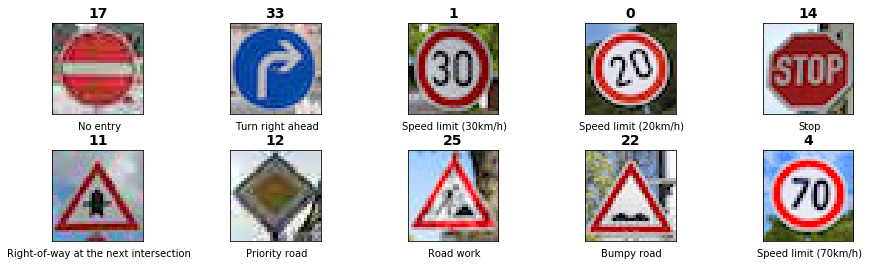

In [56]:
import matplotlib.image as mpimg

def load_test_images(input_folder = 'test_images'):
    X = []
    y = []
    for file in os.listdir('test_images'):
        if file.endswith('.jpg'):
            X.append(mpimg.imread(os.path.join(input_folder, file)))
            y.append(int(file[:-4]))
            
    return X, y

X_ext, y_ext = load_test_images()

plot_images(X_ext, y_ext)

### Predict the Sign Type for Each Image

We can run now our model on the testing images and see how it behaves.

Our final model that will be used in the following is the VGGLikeNetV8 trained on 40 epochs with the following parameters:

- Epochs: 50
- Batch size: 128
- Learning rate: 0.00025
- Dropout probability (Fully connected): 0.5
- L2 Beta: 0.0001
- Batch Norm Decay: 0.9

The accuracy of the model was as follow:

- Training: 1.0
- Validation: 0.996
- Testing: 0.992

Let us now see how it behaves on the new images:

Pre-processing: 100%|██████████| 10/10 [00:00<00:00, 1679.67 images/s]


INFO:tensorflow:Restoring parameters from models/VGGLikeNetV8_8.ckpt


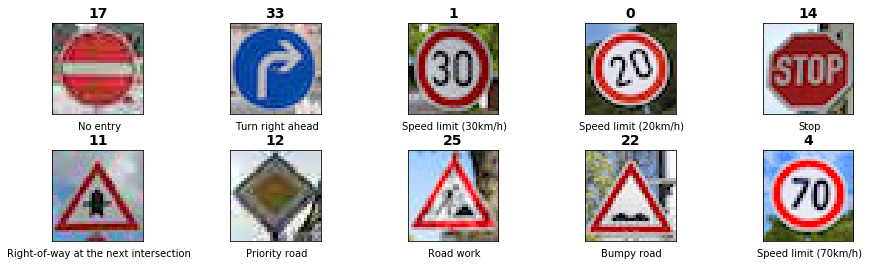

In [146]:
X_ext_processed, y_ext_processed = preprocess_data(X_ext, y_ext, shuffle_data = False)

tf.reset_default_graph()
final_model = final_params['model'](final_params['l2_beta'], final_params['bn_decay'])

def compute_predictions(model, params, X):
    
    with tf.Session() as sess:
        model.restore(params, sess)
        pred, prob = model.predict(X, params, sess)
        return pred, prob

pred, prob = compute_predictions(final_model, final_params, X_ext_processed)

plot_images(X_ext, pred)

The predictions are shown on top of each image, looks like it got all the images right, even the 20km/h speed limit which was underepresented in the original dataset and in this image is also rotated. This may mean that the model is generalizing well.

### Analyze Performance

We can now evaluate the model on this small dataset, considering that all the previous images were classified correctly we expect a 100% accuracy:

In [147]:
def compute_accuracy(model, params, X, y):
    with tf.Session() as sess:
        model.restore(params, sess)
        loss, acc = model.evaluate(X, y, params, sess)
        return loss, acc

loss, acc = compute_accuracy(final_model, final_params, X_ext_processed, y_ext_processed)

print("Accuracy of the model on the new images:", acc)

INFO:tensorflow:Restoring parameters from models/VGGLikeNetV8_8.ckpt
Accuracy of the model on the new images: 1.0


As expected the accuracy is 1.0 as all the images were classifed correctly. The model is not perfect though as shown in the previous section where an analysis of the confusion matrix, precision and recall for the testing dataset provided insights into the weaknesses of the model for a few of the signs. Most likely training for more epochs or proving better augmentation would have led to better results.

### Top 5 Softmax Probabilities

We can now check how confident is the model for each prediction on the new images, this will give us more insights on the decision taken for each prediction:

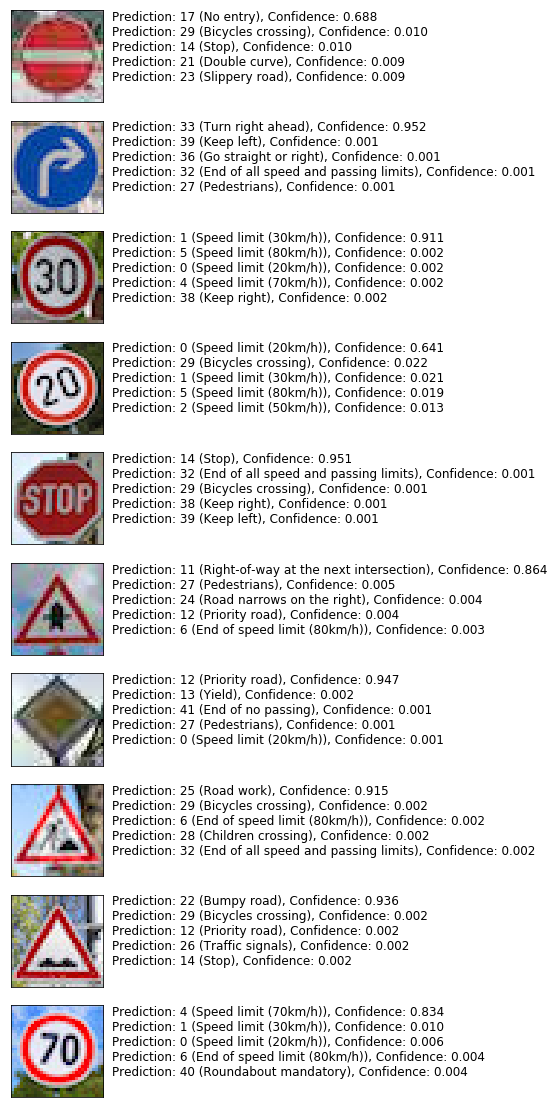

In [162]:
def plot_top_k(X, top_k):
    
    plt.figure(figsize = (10, 20))

    for i, img in enumerate(X):
        indices = top_k.indices[i]
        values = top_k.values[i]
        ax = plt.subplot(10, 1, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)

        text = ''

        for j, idx in enumerate(indices):


            sign = labels_map[idx][0]
            sign_label = labels_map[idx][1]
            sign_p = values[j]

            text += "Prediction: {} ({}), Confidence: {:.3f}\n".format(sign, sign_label, sign_p)

        plt.text(1.1, 1, text, horizontalalignment='left', verticalalignment='top', fontsize = 12, transform=ax.transAxes)
        
    plt.show()

def compute_top_k(prob):
    with tf.Session() as sess:
        return sess.run(tf.nn.top_k(prob, k = 5))

# prob was computed in the previous cell for the predictions
top_k = compute_top_k(prob)
plot_top_k(X_ext, top_k)
    

We can see that the model works quite well on the new images, and the confidence of the predictions is relatively high for the correct prediction and very low for the ones that are not choosen. This is a good sign that the model is generalizing well on the subject.

---

## Step 4: Visualize the Neural Network's State

 While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training the neural network we can see what its feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

In [149]:
# sess: The tensorflow session to use
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# feed_dict: The dictionary to feed to the session containing the image
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(sess, tf_activation, feed_dict, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess, feed_dict=feed_dict)
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

We can visualize the first three layers of the network and see how it looks on various signs (we limit the number of feature maps to 8):

INFO:tensorflow:Restoring parameters from models/VGGLikeNetV8_8.ckpt
Turn right ahead


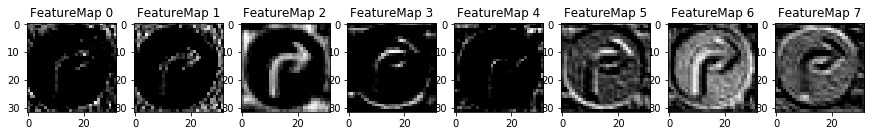

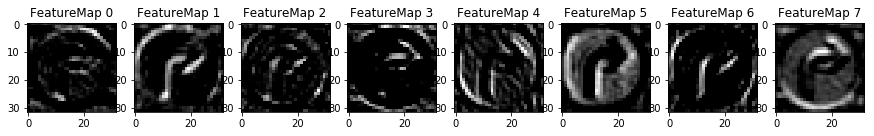

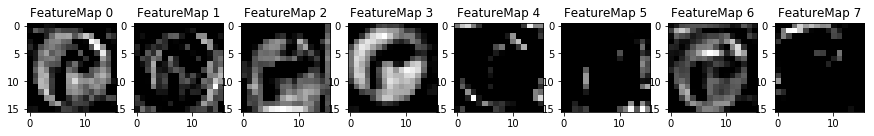

Speed limit (20km/h)


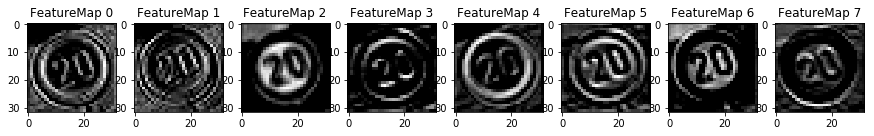

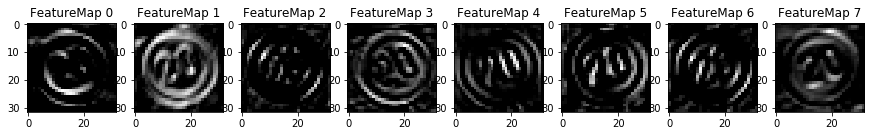

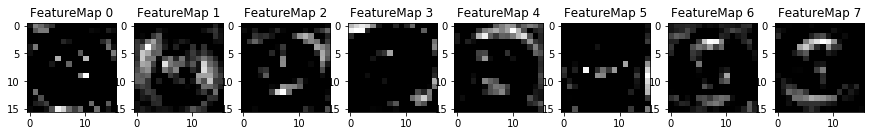

Stop


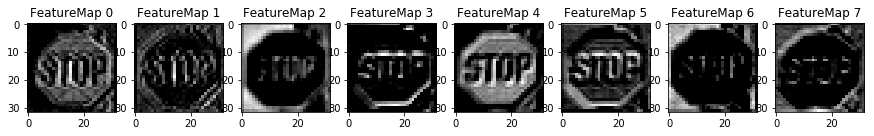

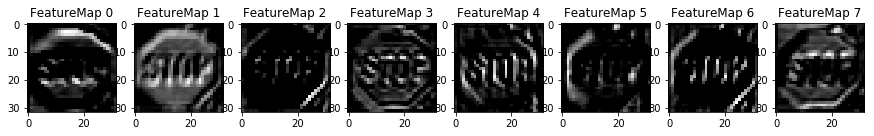

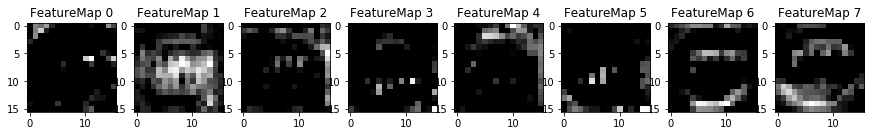

In [154]:
def visualize_fmap(params, images, layers = 3, max_f_maps = 8):

    tf.reset_default_graph()
    model = params['model'](l2_reg = params['l2_reg'], batch_normalize = params['batch_normalize'])
    
    with tf.Session() as sess:
        
        model.restore(params, sess)

        for img, label in images:
            if label is not None:
                print(labels_map[label][1])
            else:
                print('No label')
            feed_dict = {
                model.features: [img],
                model.keep_probability: 1,
                model.l2_beta: params['l2_beta'],
                model.bn_decay: params['bn_decay'],
                model.is_training: False
            }

            for i, a in enumerate(model.activations[:layers]):
                outputFeatureMap(sess, a[:, :, :, :max_f_maps], feed_dict, activation_min=-1, activation_max=-1 , plt_num=i+1)
                
            plt.show()
            
visualize_fmap(final_params, [(X_ext_processed[1], y_ext_processed[1]),
                              (X_ext_processed[3], y_ext_processed[3]),
                              (X_ext_processed[4], y_ext_processed[4])])

We can see that the model seems to capture the more relevant features of the image such as the border of the sign and the constrast of the drawing inside the sign even when rotated (e.g. the 20km/h limit sign).

We can try to do the same on a LeNet training for a few epochs and see the result:

Training LeNet #1000, 117390 samples (EP: 3, BS: 128, LR: 0.0001, KP: 1.0, L2: OFF, BN: OFF)...

EPOCH 1 (10.2 s, 918): Train Loss/Accuracy: (1.1448, 0.6928) Validation Loss/Accuracy: (1.1087, 0.6891)
EPOCH 2 (9.8 s, 1836): Train Loss/Accuracy: (0.7276, 0.8088) Validation Loss/Accuracy: (0.7350, 0.8041)
EPOCH 3 (9.3 s, 2754): Train Loss/Accuracy: (0.5533, 0.8537) Validation Loss/Accuracy: (0.6066, 0.8351)
Training finished (33.1 s)
Model saved in path: models/LeNet_1000.ckpt
INFO:tensorflow:Restoring parameters from models/LeNet_1000.ckpt
Loss: 0.553, 0.607, 0.611 - Accuracy: 0.854, 0.835, 0.828


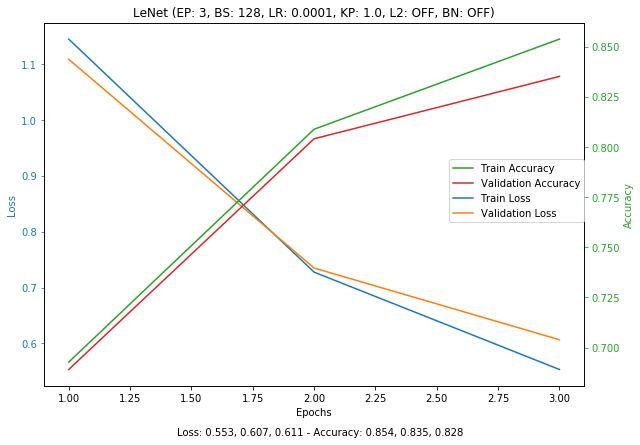

In [127]:
tf.reset_default_graph()

f_map_experiments = [{
    'run_n'           : 1000,
    'model'           : LeNet,
    'l2_reg'          : False,
    'batch_normalize' : False,
    'X'               : X_train_final,
    'y'               : y_train_final,
    'X_valid'         : X_valid_final,
    'y_valid'         : y_valid_final,
    'epochs'          : 3,
    'batch_size'      : 128,
    'learning_rate'   : 0.0001,
    'keep_probability': 1.0,
    'l2_beta'         : 0.0001,
    'bn_decay'        : 0.9,
    'skip'            : False
}]

f_map_results = run_experiments(f_map_experiments)

INFO:tensorflow:Restoring parameters from models/LeNet_1000.ckpt
Turn right ahead


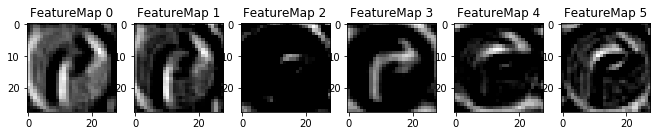

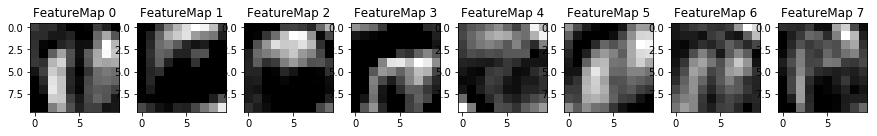

Speed limit (20km/h)


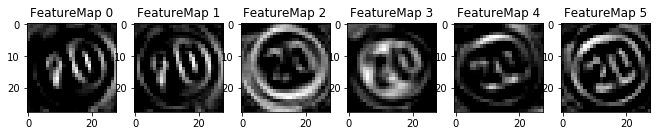

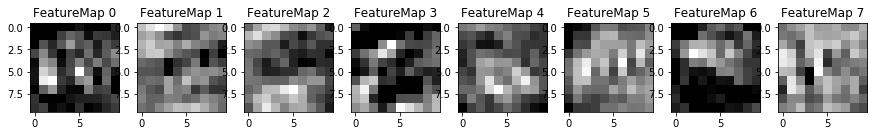

Stop


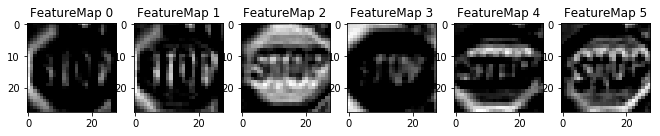

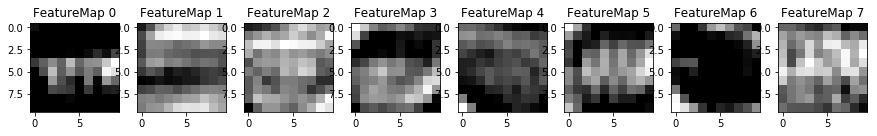

In [155]:
visualize_fmap(f_map_experiments[0], [(X_ext_processed[1], y_ext_processed[1]),
                              (X_ext_processed[3], y_ext_processed[3]),
                              (X_ext_processed[4], y_ext_processed[4])], layers = 2, max_f_maps = 8)

We can notice that it still manages to capture some of the relevant features but the noise is much higher (indication of not enough training). 

What about an image without a traffic sign? Let us try on our model:

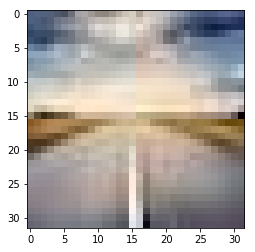

Pre-processing: 100%|██████████| 1/1 [00:00<00:00, 148.58 images/s]


INFO:tensorflow:Restoring parameters from models/VGGLikeNetV8_8.ckpt
No label


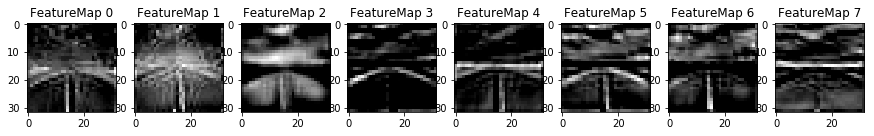

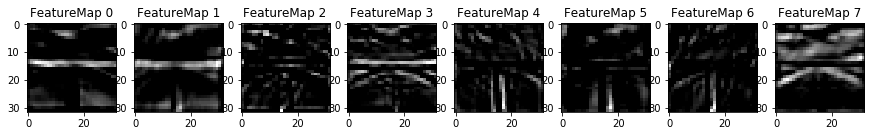

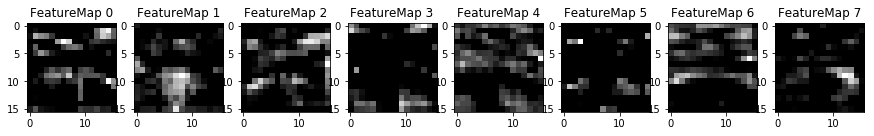

In [180]:
img_no_sign = mpimg.imread(os.path.join('images', 'no_sign.jpg'))

plt.figure()
plt.imshow(img_no_sign)
plt.show()

img_no_sign_p, _ = preprocess_data([img_no_sign], [None])

visualize_fmap(final_params, [(img_no_sign_p[0], None)], layers = 3, max_f_maps = 8)

We can see a lot of noise, so most likley this will not be classifed as much:

INFO:tensorflow:Restoring parameters from models/VGGLikeNetV8_8.ckpt


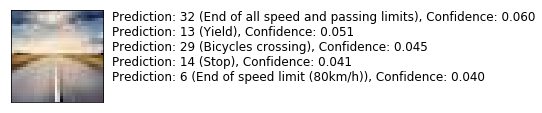

In [182]:
tf.reset_default_graph()

final_model = final_params['model'](final_params['l2_reg'], final_params['batch_normalize'])

with tf.Session() as sess:
        final_model.restore(final_params, sess)
        pred_no_sign, prob_no_sign = final_model.predict(img_no_sign_p, final_params, sess)
        top_k_no_sign = sess.run(tf.nn.top_k(prob_no_sign, k = 5))
        plot_top_k([img_no_sign], top_k_no_sign)

As we can see the prediction confidence is very low, which is a good sign for our model.